## Исследование датасета Wine Reviews и определение качества вина по описанию.

https://www.kaggle.com/zynicide/wine-reviews

## Context
    After watching Somm (a documentary on master sommeliers) I wondered how I could create a predictive model to identify wines through blind tasting like a master sommelier would. The first step in this journey was gathering some data to train a model. I plan to use deep learning to predict the wine variety using words in the description/review. The model still won't be able to taste the wine, but theoretically it could identify the wine based on a description that a sommelier could give. If anyone has any ideas on how to accomplish this, please post them!

    winemag-data_first150k.csv contains 10 columns and 150k rows of wine reviews.

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot


seed = 42
np.random.seed(seed)

In [47]:
data = pd.read_csv('winemag-data-130k-v2.csv', 
                   delimiter=',', 
                   #nrows = 100
                  )

In [48]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Описание данных:
* country - страна происхождения вина.
* description - рецензия на вино
* designation - виноградник где выращивается вино
* points - оценка вина выставленная на сайте ВЕ от 0 до 100
* price - цена вина в долларах США
* province - область происхождения вина
* region_1 - особое место или регион в области происхождения
* region_2 - более конкретное место происхождения, уточняет предыдущий пункт
* taster_name - имя ревьюера
* taster_twitter_handle - твиттер ревьюера
* title - наименование вина
* variety - сорт винограда
* winery - наименование винодельни

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


### Подготовка данных

Для начала уберем дублирующиеся записи:

In [50]:
data.shape

(129971, 14)

In [51]:
data.drop_duplicates(('description', 'title'), inplace=True)

In [52]:
data.shape

(119988, 14)

Оценим количество пропущенных значений:

In [53]:
data.isnull().sum()

Unnamed: 0                   0
country                     59
description                  0
designation              34545
points                       0
price                     8395
province                    59
region_1                 19560
region_2                 73219
taster_name              24917
taster_twitter_handle    29446
title                        0
variety                      1
winery                       0
dtype: int64

Нам нужно обработать столбцы 'price', 'country', 'variety'. Столбцы 'taster_name' и 'taster_twitter_handle' можно отбросить поскольку нас не интересуют персональные вкусы конкретных ревьюеров. Отбрасываем пропущенные значения в столбцах 'country', 'variety', т.к. их количество незначительно. И заполняем пропущенные значения в стоблце 'price' медианой.

In [54]:
data = data.dropna(how="any", subset=["country"])
data = data.dropna(how="any", subset=["variety"])
data.drop(['taster_name', 'taster_twitter_handle'], axis='columns', inplace=True)

In [55]:
print(data.price.median())
print(data.price.mean())
print(data.price.mode())

25.0
35.62627648224356
0    20.0
dtype: float64


In [56]:
data['price'] = data['price'].fillna(data.price.median())

In [57]:
data.isnull().sum()

Unnamed: 0         0
country            0
description        0
designation    34534
points             0
price              0
province           0
region_1       19500
region_2       73159
title              0
variety            0
winery             0
dtype: int64

### Визуализация данных

Изучим основные описательные статистики по столбцам и заодно проведем визуализацию данных:

<AxesSubplot:>

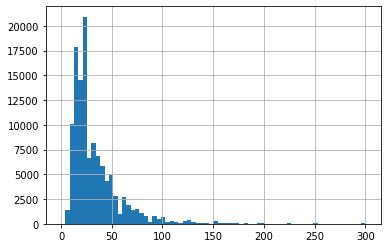

In [58]:
data['price'].hist(bins=70, range=[0,300])

In [59]:
data['price'].describe()

count    119928.000000
mean         34.882788
std          40.703435
min           4.000000
25%          18.000000
50%          25.000000
75%          40.000000
max        3300.000000
Name: price, dtype: float64

<AxesSubplot:>

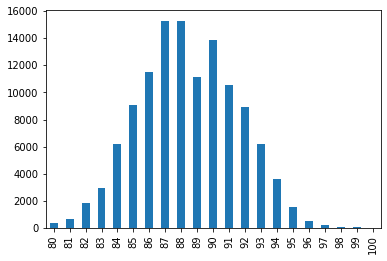

In [60]:
data['points'].value_counts().sort_index().plot.bar()

In [61]:
data['points'].describe()

count    119928.000000
mean         88.442149
std           3.093287
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

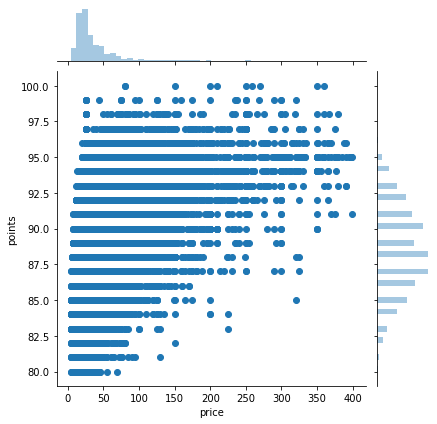

In [62]:
sns.jointplot(x='price', y='points', data=data[data['price'] < 400])

<AxesSubplot:xlabel='price', ylabel='points'>

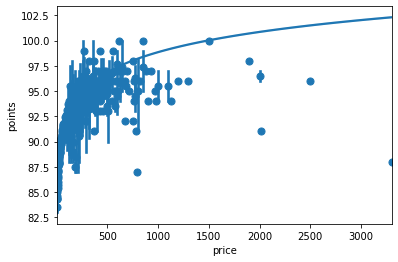

In [63]:
sns.regplot(x=data["price"], y="points", data=data, x_estimator=np.mean, logx=True, truncate=True)

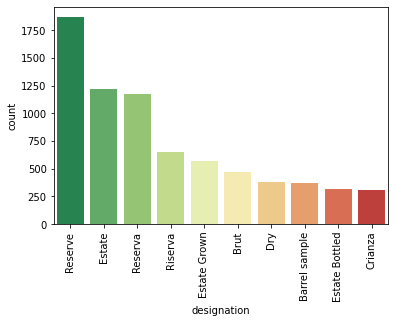

In [64]:
sns.countplot('designation',data=data,palette='RdYlGn_r',order=data['designation'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.show()

In [65]:
data["designation"].describe()

count       85394
unique      37954
top       Reserve
freq         1868
Name: designation, dtype: object

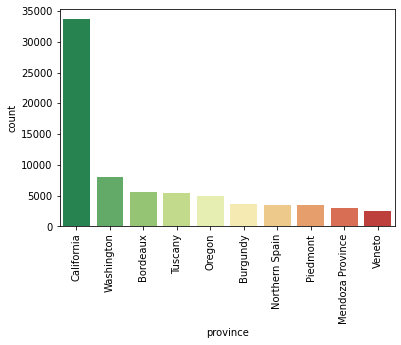

In [66]:
sns.countplot('province',data=data,palette='RdYlGn_r',order=data['province'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.show()

In [67]:
data["province"].describe()

count         119928
unique           425
top       California
freq           33656
Name: province, dtype: object

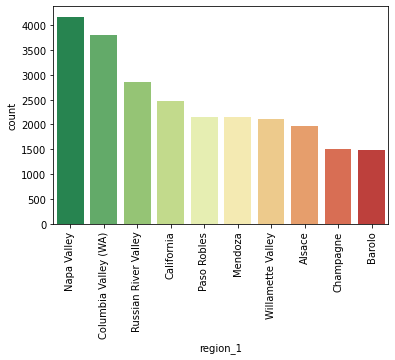

In [68]:
sns.countplot('region_1',data=data,palette='RdYlGn_r',order=data['region_1'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.show()

In [69]:
data["region_1"].describe()

count          100428
unique           1229
top       Napa Valley
freq             4174
Name: region_1, dtype: object

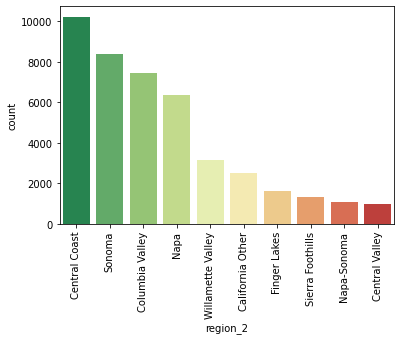

In [70]:
sns.countplot('region_2',data=data,palette='RdYlGn_r',order=data['region_2'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.show()

In [71]:
data["region_2"].describe()

count             46769
unique               17
top       Central Coast
freq              10233
Name: region_2, dtype: object

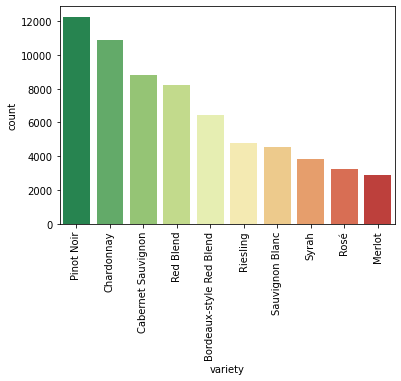

In [72]:
sns.countplot('variety',data=data,palette='RdYlGn_r',order=data['variety'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.show()

In [73]:
data["variety"].describe()

count         119928
unique           701
top       Pinot Noir
freq           12275
Name: variety, dtype: object

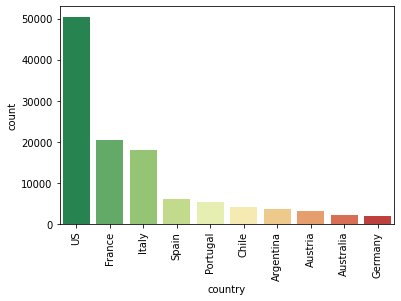

In [74]:
sns.countplot('country',data=data,palette='RdYlGn_r',order=data['country'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.show()

In [75]:
data["country"].describe()

count     119928
unique        43
top           US
freq       50457
Name: country, dtype: object

## Задача проекта: По описанию вина определим его качество - Отличное (больше 90 баллов) или Обычное

In [76]:
import tensorflow as tf
from keras import preprocessing

max_features = 10000 
maxlen = 50


In [77]:
data['description'] = data['description'].astype('str')

filtered = data[data.description.str.split().apply(len) > 15]
data = filtered[filtered.description.str.split().apply(len) < 50]

In [78]:
data["categorical"] = [1 if score > 90 else 0 for score in data.points]

<ipython-input-78-b5721dffe50e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["categorical"] = [1 if score > 90 else 0 for score in data.points]


In [79]:
x_train, x_test, y_train, y_test = train_test_split(data.description, data.categorical, 
                                                    test_size = 0.25, 
                                                    random_state = 42)

In [80]:
def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

In [81]:
SENTENCE_LENGTH = 50

NUM = 10000 # словарь

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

In [82]:
x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

Попробуем полносвязную сеть.

In [83]:
model = Sequential()

model.add(Embedding(10000, 128))

model.add(Dense(1000, activation = "relu"))
model.add(Dense(2000, activation = "relu"))

model.add(Dense(50, activation = "relu"))

model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
dense_4 (Dense)              (None, None, 1000)        129000    
_________________________________________________________________
dense_5 (Dense)              (None, None, 2000)        2002000   
_________________________________________________________________
dense_6 (Dense)              (None, None, 50)          100050    
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           51        
Total params: 3,511,101
Trainable params: 3,511,101
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics = ["accuracy"])

results = model.fit(
    x_train_seq, y_train, 
    batch_size=128, 
    epochs= 2,
    validation_data = (x_test_seq, y_test))
  


score, acc = model.evaluate(x_test_seq, y_test,
                            batch_size=128)


print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/2
566/566 [==============================] - 348s 615ms/step - loss: 0.4866 - accuracy: 0.8019 - val_loss: 0.4753 - val_accuracy: 0.8069
Epoch 2/2
189/189 [==============================] - 38s 199ms/step - loss: 0.4756 - accuracy: 0.8072
Test score: 0.47564542293548584
Test accuracy: 0.8072353601455688


Реккурентная сеть LSTM

In [85]:
model = Sequential()

model.add(Embedding(10000, 128))

model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))

model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))

model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 1,549,669
Trainable params: 1,549,669
Non-trainable params: 0
____________________________________________

In [86]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics = ["accuracy"])

results = model.fit(
    x_train_seq, y_train, 
    batch_size=128, 
    epochs= 2,
    validation_data = (x_test_seq, y_test))
  


score, acc = model.evaluate(x_test_seq, y_test,
                            batch_size=128)


print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/2
566/566 [==============================] - 123s 213ms/step - loss: 0.3690 - accuracy: 0.8403 - val_loss: 0.2897 - val_accuracy: 0.8748
Epoch 2/2
189/189 [==============================] - 16s 84ms/step - loss: 0.2837 - accuracy: 0.8750
Test score: 0.2837337851524353
Test accuracy: 0.8749585747718811


На полносвязной сети получили точность около 80% что не является особенно хорошим результатом. На реккурентной удалось получить точность поряка 87%. В дальнейшем если подобрать параметры нейросетей лучше и обучать дольше возможно будет получить лучшие результаты.

Использование модели: для примера возьмем один из текстов. Преобразуем в вектор и оценим предсказание.

In [87]:
f9 = x_train[36789]
print(f9)
y9 = y_train[36789]

MacRostie's Wildcat Mountain Pinot is always an interesting wine, but it's vintage-driven, and this 2010 shows challenges. There's a vegetal, mushroomy streak to the raspberry fruit that makes the palate recoil. Compared to the lush 2009, it's a disappointment.


In [88]:
f = [one_hot(f9, 10000)]

f

[[7751,
  825,
  2413,
  6529,
  6960,
  510,
  5596,
  9593,
  2508,
  5276,
  6827,
  3294,
  8969,
  8381,
  792,
  3769,
  9262,
  1067,
  8583,
  8874,
  2040,
  6556,
  8246,
  2559,
  2271,
  7151,
  3011,
  3548,
  6814,
  2271,
  4490,
  7530,
  3613,
  2559,
  2271,
  781,
  566,
  6827,
  8874,
  9837]]

In [89]:
x = sequence.pad_sequences(f, maxlen=50)
print(x.shape)
model.predict(x)

(1, 50)


array([[0.00461885]], dtype=float32)

In [90]:
y9

0

Вино - обычное.

В дальнейшем можно сделать рекомендательную систему которая по описанию вина будет находить лучшие подобные вина из датасета например.